# CATE Estimation with Causal Effect Variational Autoencoder (CEVAE)

This notebook demonstrates Conditional Average Treatment Effect (CATE) estimation
using a CEVAE-style model in NumPyro. The approach follows the methodology from
the [ChiRho CEVAE tutorial](https://basisresearch.github.io/chirho/cevae.html).

**Key insights:**
1. Use separate linear outcome networks for each treatment level (t=0, t=1)
2. Each network takes only z as input, forcing it to learn z-dependent functions
3. At test time, infer z from x only (not t and y) for CATE prediction

## Setup

In [ ]:
from itertools import pairwise

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import optax
from flax import nnx
from jax import random
from jaxtyping import Array, Float, Int
from numpyro.contrib.module import nnx_module
from numpyro.handlers import condition, seed, trace
from numpyro.infer import SVI, Predictive, Trace_ELBO

plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

rng_key = random.PRNGKey(seed=42)

## Data Generating Process (DGP)

We simulate data with a latent binary confounder z that affects both
treatment assignment and outcome:
- z ~ Bernoulli(0.5)
- x | z ~ Normal(z * z_gap, variance depending on z)
- t | z ~ Bernoulli(0.75*z + 0.25*(1-z))
- y | z, t ~ Bernoulli(logits = y_gap * (z + 2*(2*t - 1)))

In [ ]:
# Parameters
NUM_TRAIN = 10_000
NUM_TEST = 2_000
FEATURE_DIM = 10
Z_GAP = 1.0
Y_GAP = 3.0


def generate_data(
    num_data: int, feature_dim: int, z_gap: float, y_gap: float
) -> tuple[Array, Array, Array, Array]:
    """Generate synthetic data with latent confounder."""
    with numpyro.plate("num_data", num_data):
        z = numpyro.sample("z", dist.Bernoulli(0.5))

        with numpyro.plate("feature_dim", feature_dim):
            x = numpyro.sample("x", dist.Normal(z * z_gap, 5 * z + 3 * (1 - z))).T

        t = numpyro.sample("t", dist.Bernoulli(0.75 * z + 0.25 * (1 - z)))
        y = numpyro.sample("y", dist.Bernoulli(logits=y_gap * (z + 2 * (2 * t - 1))))

        return x, t, y, z

In [ ]:
# Generate training data
rng_key, rng_subkey = random.split(rng_key)
x_train, t_train, y_train, _ = trace(seed(generate_data, rng_subkey))(
    NUM_TRAIN, FEATURE_DIM, Z_GAP, Y_GAP
)

# Generate test data (keep z for evaluation)
rng_key, rng_subkey = random.split(rng_key)
x_test, t_test, y_test, z_test = trace(seed(generate_data, rng_subkey))(
    NUM_TEST, FEATURE_DIM, Z_GAP, Y_GAP
)

# Compute true CATE for evaluation
true_cate_probs = jax.nn.sigmoid(Y_GAP * (z_test + 2)) - jax.nn.sigmoid(
    Y_GAP * (z_test - 2)
)

print(f"True CATE (z=0): {true_cate_probs[z_test == 0].mean():.4f}")
print(f"True CATE (z=1): {true_cate_probs[z_test == 1].mean():.4f}")

True CATE (z=0): 0.9951
True CATE (z=1): 0.9524


## Neural Network Components

In [ ]:
LATENT_DIM = 1
HIDDEN_DIM = 50
NUM_LAYERS = 2


class FullyConnected(nnx.Module):
    """Base fully connected network with ELU activations."""

    def __init__(
        self, din: int, dout: int, hidden_layers: list[int], *, rngs: nnx.Rngs
    ) -> None:
        self.layers = nnx.List([])
        layer_dims = [din, *hidden_layers, dout]
        for in_dim, out_dim in pairwise(layer_dims):
            self.layers.append(nnx.Linear(in_dim, out_dim, rngs=rngs))

    def __call__(self, x: Array) -> Array:
        for layer in self.layers:
            x = jax.nn.elu(layer(x))
        return x


class DiagNormalNet(FullyConnected):
    """Network outputting mean and scale for a diagonal normal distribution."""

    def __init__(
        self, din: int, dout: int, hidden_layers: list[int], *, rngs: nnx.Rngs
    ):
        super().__init__(din, 2 * dout, hidden_layers, rngs=rngs)

    def __call__(self, x: Array) -> tuple[Array, Array]:
        loc, scale = jnp.split(super().__call__(x), 2, axis=-1)
        return loc, jax.nn.softplus(scale)


class BernoulliNet(FullyConnected):
    """Network outputting logits for a Bernoulli distribution."""

    def __call__(self, x: Array) -> Array:
        return jax.lax.clamp(-10.0, super().__call__(x), 10.0)


class Encoder(nnx.Module):
    """Encoder for amortized variational inference q(z|inputs)."""

    def __init__(
        self,
        input_dim: int,
        latent_dim: int,
        hidden_layers: list[int],
        *,
        rngs: nnx.Rngs,
    ) -> None:
        self.layers = nnx.List([])
        layer_dims = [input_dim, *hidden_layers]
        for in_dim, out_dim in pairwise(layer_dims):
            self.layers.append(nnx.Linear(in_dim, out_dim, rngs=rngs))

        final_dim = hidden_layers[-1] if hidden_layers else input_dim
        self.f_loc = nnx.Linear(final_dim, latent_dim, rngs=rngs)
        self.f_scale = nnx.Linear(final_dim, latent_dim, rngs=rngs)

    def __call__(self, x: Array) -> tuple[Array, Array]:
        for layer in self.layers:
            x = jax.nn.elu(layer(x))
        return self.f_loc(x), jax.nn.softplus(self.f_scale(x)) + 1e-6

In [ ]:
# Initialize networks
hidden_layers = [HIDDEN_DIM] * NUM_LAYERS

rng_key, *subkeys = random.split(rng_key, 7)

# Decoder networks
x_nn_module = DiagNormalNet(
    LATENT_DIM, FEATURE_DIM, hidden_layers, rngs=nnx.Rngs(subkeys[0])
)
t_nn_module = BernoulliNet(LATENT_DIM, 1, hidden_layers, rngs=nnx.Rngs(subkeys[1]))

# Separate LINEAR outcome networks for t=0 and t=1
# Key: Using linear layers forces them to use z (cannot collapse to constants)
y_nn_t0_module = nnx.Linear(LATENT_DIM, 1, rngs=nnx.Rngs(subkeys[2]))
y_nn_t1_module = nnx.Linear(LATENT_DIM, 1, rngs=nnx.Rngs(subkeys[3]))

# Training encoder: q(z|x,t,y)
encoder_module = Encoder(
    FEATURE_DIM + 2, LATENT_DIM, hidden_layers, rngs=nnx.Rngs(subkeys[4])
)

# Test-time encoder: q(z|x) - infers z from x only
test_encoder_module = Encoder(
    FEATURE_DIM, LATENT_DIM, hidden_layers, rngs=nnx.Rngs(subkeys[5])
)

## Model and Guide Definitions

In [ ]:
def model(
    x: Float[Array, "n d"],
    t: Int[Array, " n"],
    y: Int[Array, " n"] | None = None,
    latent_dim: int = 1,
) -> None:
    """Generative model with latent confounder z."""
    num_data = x.shape[0]

    x_nn = nnx_module("x_nn", x_nn_module)
    t_nn = nnx_module("t_nn", t_nn_module)
    y_nn_t0 = nnx_module("y_nn_t0", y_nn_t0_module)
    y_nn_t1 = nnx_module("y_nn_t1", y_nn_t1_module)

    with numpyro.plate("obs", num_data):
        # Latent confounder
        z = numpyro.sample("z", dist.Normal(0, 1).expand([latent_dim]).to_event(1))

        # Covariates depend on z
        x_loc, x_scale = x_nn(z)
        numpyro.sample("x_obs", dist.Normal(x_loc, x_scale).to_event(1))

        # Treatment depends on z
        t_logits = t_nn(z).squeeze(-1)
        t_obs = numpyro.sample("t_obs", dist.Bernoulli(logits=t_logits))

        # Potential outcomes (both computed from same z)
        y_logits_0 = y_nn_t0(z).squeeze(-1)
        y_logits_1 = y_nn_t1(z).squeeze(-1)

        # CATE = P(Y=1|do(T=1),z) - P(Y=1|do(T=0),z)
        y_prob_0 = numpyro.deterministic("y_prob_0", jax.nn.sigmoid(y_logits_0))
        y_prob_1 = numpyro.deterministic("y_prob_1", jax.nn.sigmoid(y_logits_1))
        numpyro.deterministic("CATE", y_prob_1 - y_prob_0)

        # Observed outcome uses actual treatment
        y_logits = jnp.where(t_obs == 1, y_logits_1, y_logits_0)
        numpyro.sample("y_obs", dist.Bernoulli(logits=y_logits))


def guide(
    x: Float[Array, "n d"],
    t: Int[Array, " n"],
    y: Int[Array, " n"] | None = None,
    latent_dim: int = 1,
) -> None:
    """Training guide: q(z|x,t,y)."""
    num_data = x.shape[0]
    encoder = nnx_module("encoder", encoder_module)

    encoder_input = jnp.concatenate(
        [x, t[:, None].astype(jnp.float32), y[:, None].astype(jnp.float32)], axis=-1
    )
    z_loc, z_scale = encoder(encoder_input)

    with numpyro.plate("obs", num_data):
        numpyro.sample("z", dist.Normal(z_loc, z_scale).to_event(1))


def test_guide(
    x: Float[Array, "n d"],
    t: Int[Array, " n"],
    y: Int[Array, " n"] | None = None,
    latent_dim: int = 1,
) -> None:
    """Test-time guide: q(z|x) - infers z from x only."""
    num_data = x.shape[0]
    test_encoder = nnx_module("test_encoder", test_encoder_module)

    z_loc, z_scale = test_encoder(x)

    with numpyro.plate("obs", num_data):
        numpyro.sample("z", dist.Normal(z_loc, z_scale).to_event(1))

## Stage 1: Train the Model

In [ ]:
# Condition model on training data
conditioned_model = condition(
    model, data={"x_obs": x_train, "t_obs": t_train, "y_obs": y_train}
)

100%|██████████| 20000/20000 [02:05<00:00, 159.74it/s, init loss: 2540562.0000, avg. loss [19001-20000]: 287392.2500]


CPU times: user 8min 4s, sys: 1min 58s, total: 10min 2s
Wall time: 2min 5s


Text(0, 0.5, 'Loss')

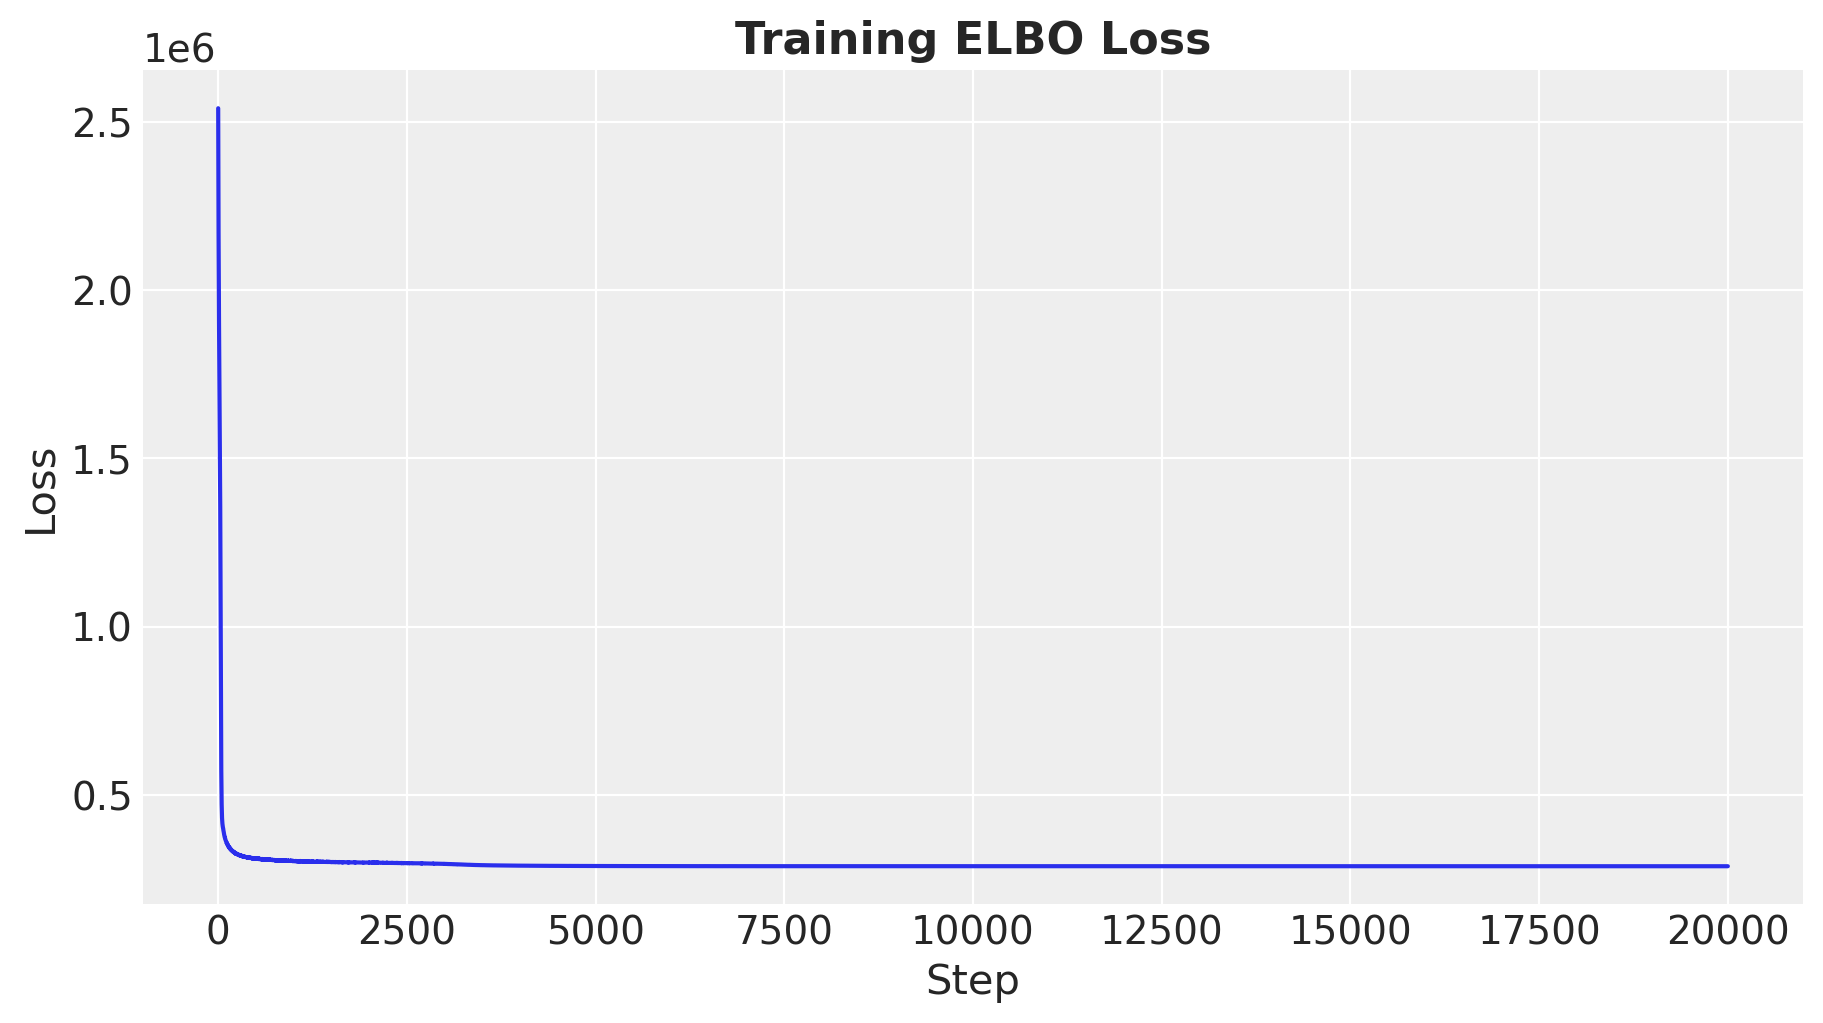

In [ ]:
%%time

num_steps = 20_000

scheduler = optax.linear_onecycle_schedule(
    transition_steps=num_steps,
    peak_value=0.001,
    pct_start=0.3,
    pct_final=0.85,
    div_factor=2,
    final_div_factor=5,
)

optimizer = optax.adam(learning_rate=scheduler)
svi = SVI(conditioned_model, guide, optimizer, loss=Trace_ELBO())

rng_key, rng_subkey = random.split(rng_key)
svi_result = svi.run(
    rng_subkey, num_steps, x=x_train, t=t_train, y=y_train, latent_dim=LATENT_DIM
)

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(svi_result.losses)
ax.set_title("Training ELBO Loss", fontsize=16, fontweight="bold")
ax.set_xlabel("Step")
ax.set_ylabel("Loss")

## Stage 2: Test-time Inference

At test time, we fit a new encoder that infers z from x only (not t and y).
This follows the ChiRho CEVAE approach.

100%|██████████| 5000/5000 [00:10<00:00, 491.68it/s, init loss: 123599.4531, avg. loss [4751-5000]: 57710.7031]


CPU times: user 23 s, sys: 4.33 s, total: 27.3 s
Wall time: 10.3 s


Text(0, 0.5, 'Loss')

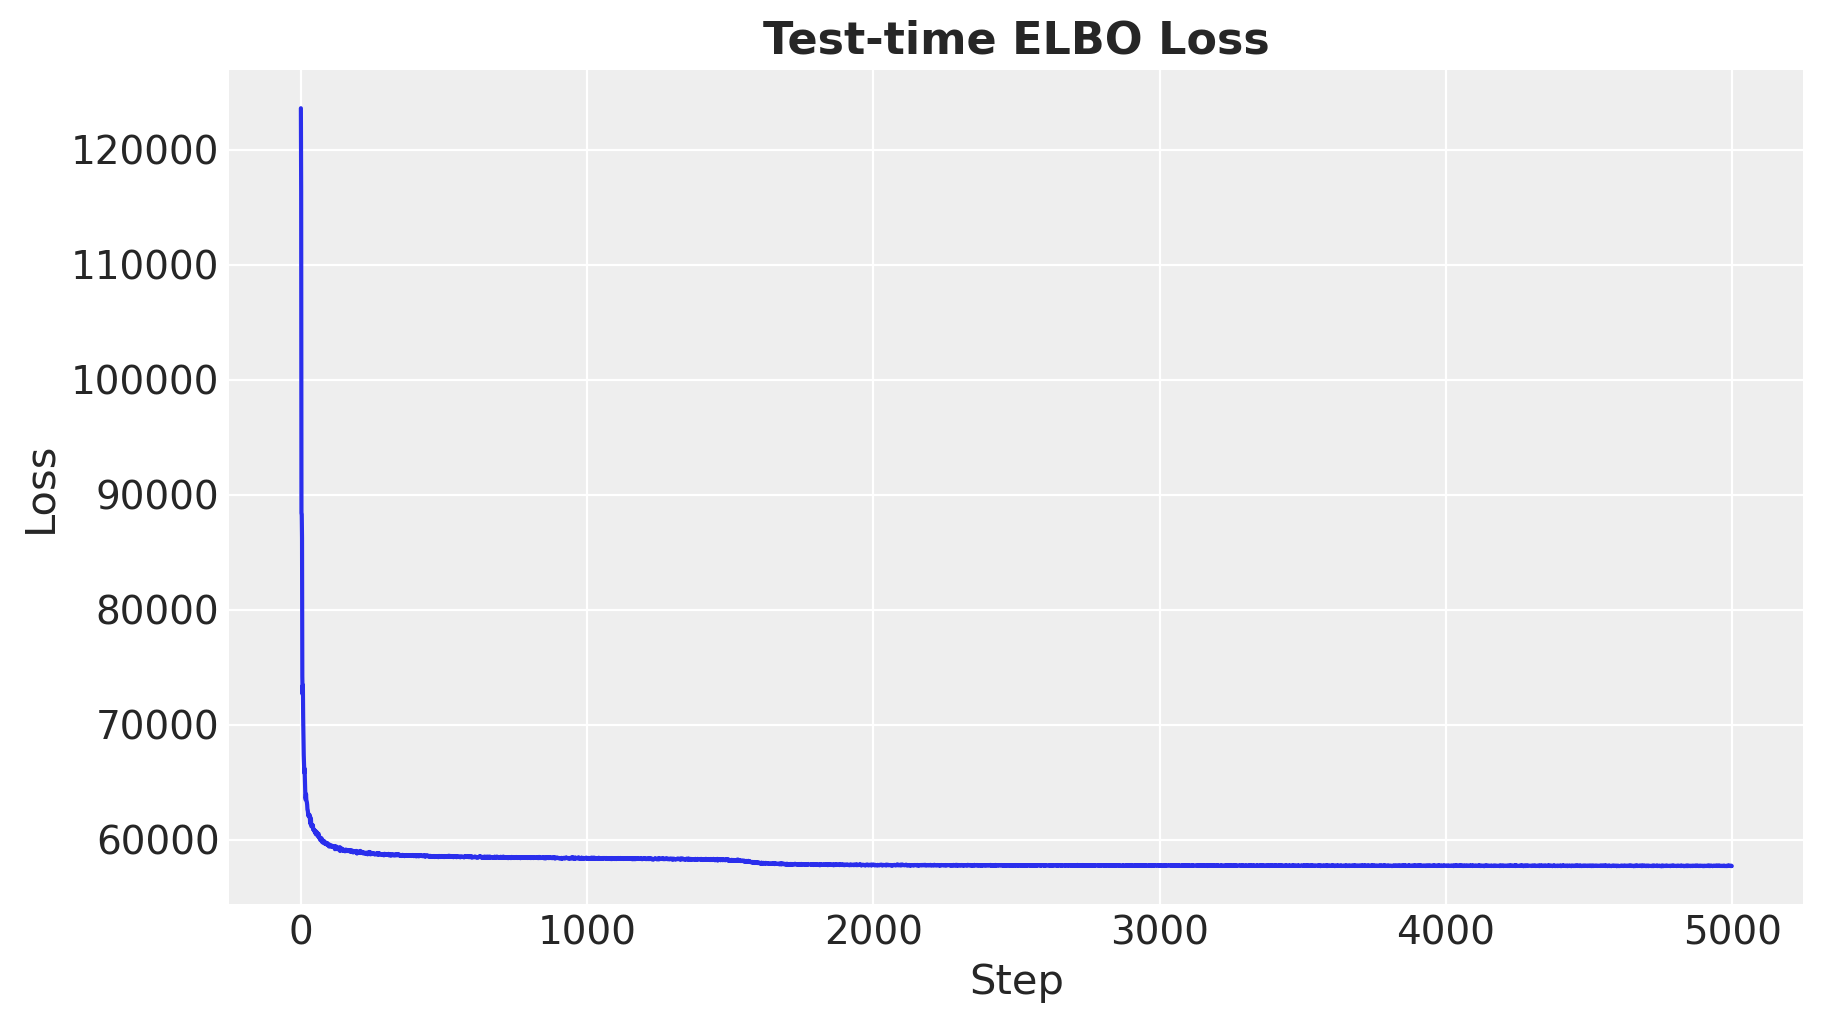

In [ ]:
%%time

params = svi_result.params

# Condition on test data
test_conditioned_model = condition(
    model, data={"x_obs": x_test, "t_obs": t_test, "y_obs": y_test}
)

test_num_steps = 5_000
test_scheduler = optax.linear_onecycle_schedule(
    transition_steps=test_num_steps,
    peak_value=0.001,
    pct_start=0.3,
    pct_final=0.85,
    div_factor=2,
    final_div_factor=5,
)
test_optimizer = optax.adam(learning_rate=test_scheduler)
test_svi = SVI(test_conditioned_model, test_guide, test_optimizer, loss=Trace_ELBO())

rng_key, rng_subkey = random.split(rng_key)
test_svi_result = test_svi.run(
    rng_subkey,
    test_num_steps,
    x=x_test,
    t=t_test,
    y=y_test,
    latent_dim=LATENT_DIM,
    init_params=params.copy(),
)

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(test_svi_result.losses)
ax.set_title("Test-time ELBO Loss", fontsize=16, fontweight="bold")
ax.set_xlabel("Step")
ax.set_ylabel("Loss")

## CATE Estimation

In [ ]:
test_params = test_svi_result.params

test_predictive = Predictive(
    model=model,
    guide=test_guide,
    params=test_params,
    num_samples=2_000,
    return_sites=["CATE", "z"],
)

rng_key, rng_subkey = random.split(rng_key)
test_samples = test_predictive(
    rng_subkey, x=x_test, t=t_test, y=y_test, latent_dim=LATENT_DIM
)

est_cates = np.asarray(test_samples["CATE"].mean(axis=0))

/var/folders/wj/wjy2vm8d7_j9v43bv29zcgl80000gq/T/ipykernel_91184/2421615369.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


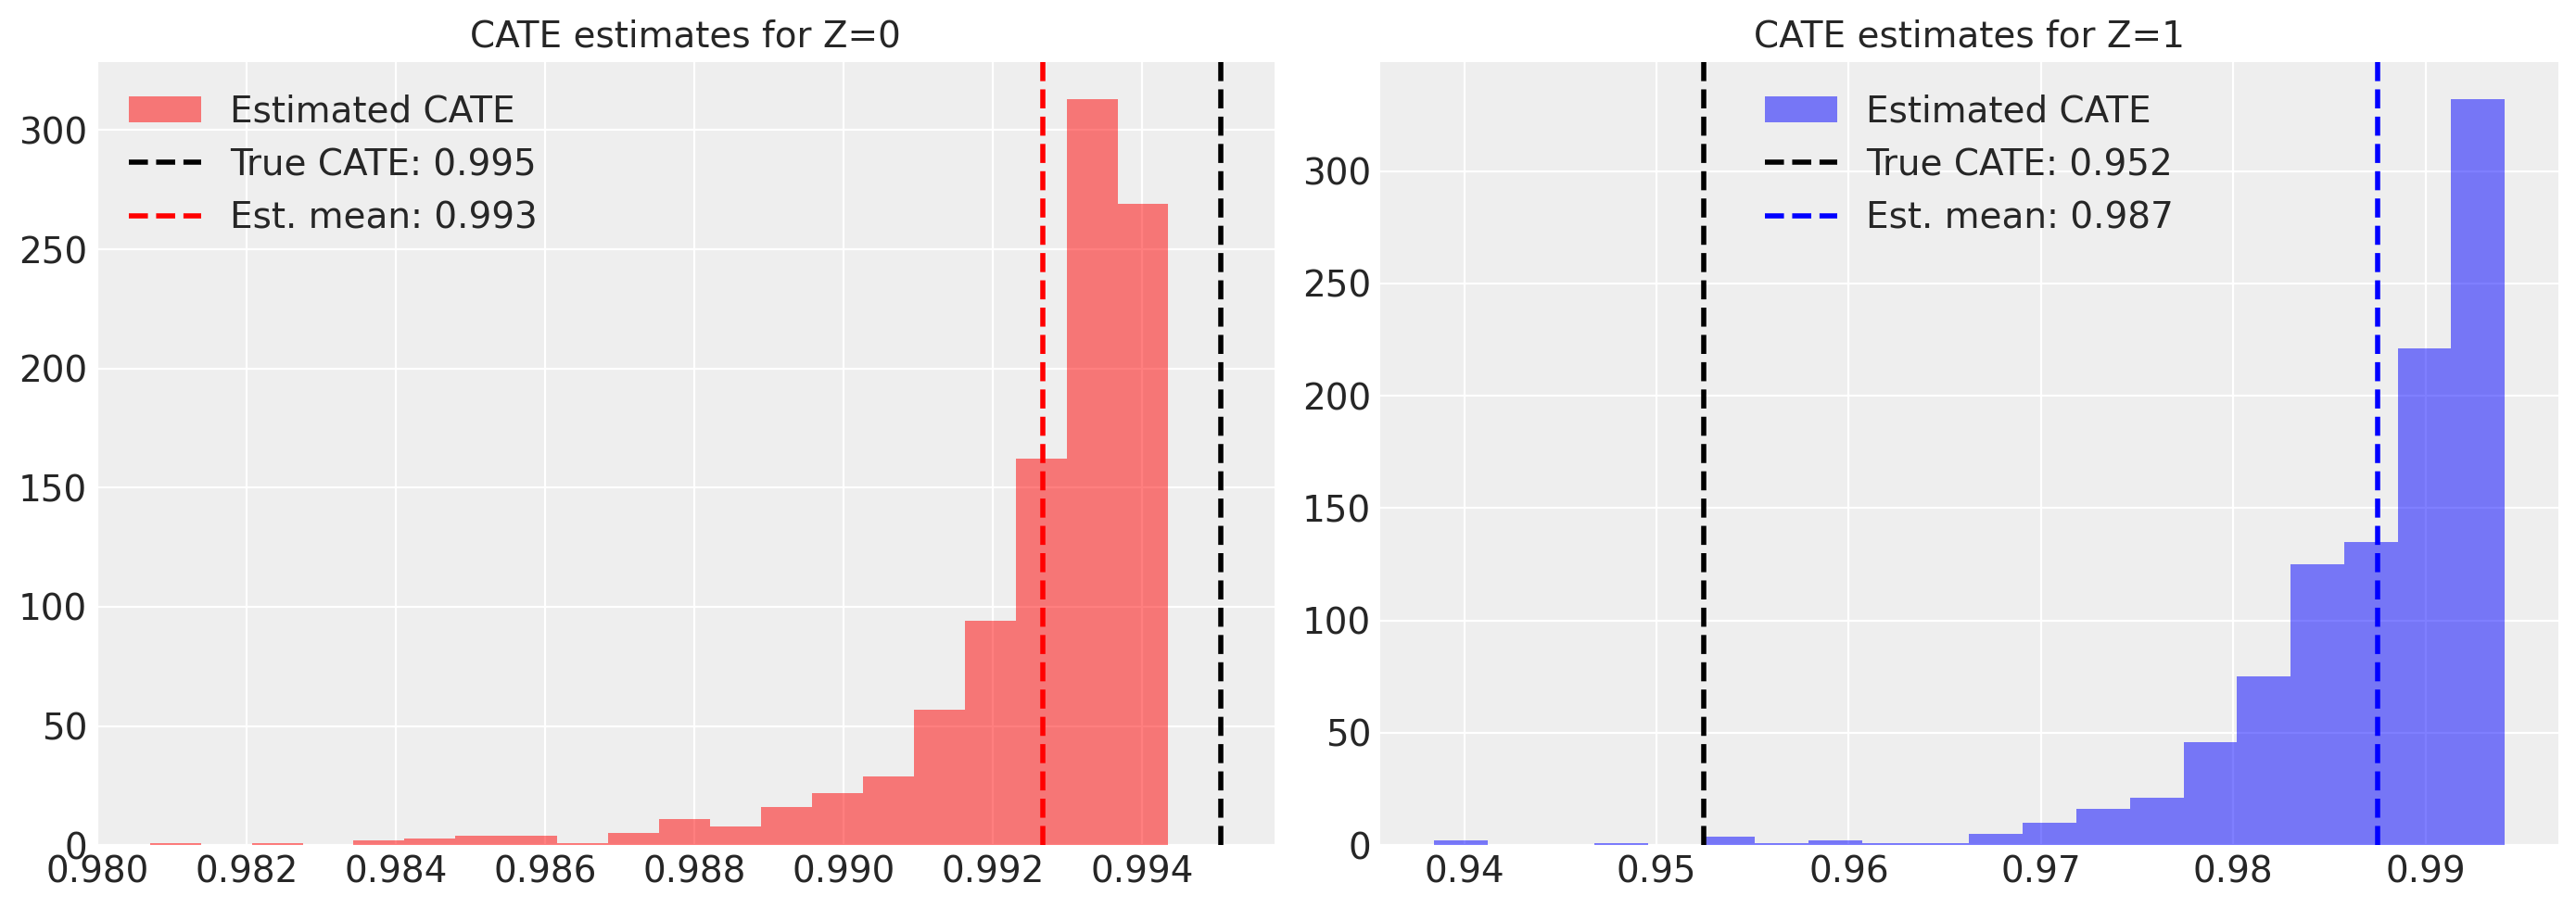

In [ ]:
# Results
est_cates_z0 = est_cates[z_test == 0]
est_cates_z1 = est_cates[z_test == 1]
true_cate_z0 = true_cate_probs[z_test == 0]
true_cate_z1 = true_cate_probs[z_test == 1]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(est_cates_z0, bins=20, color="red", alpha=0.5, label="Estimated CATE")
axes[0].axvline(
    true_cate_z0.mean().item(),
    color="black",
    linestyle="--",
    linewidth=2,
    label=f"True CATE: {true_cate_z0.mean().item():.3f}",
)
axes[0].axvline(
    est_cates_z0.mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Est. mean: {est_cates_z0.mean():.3f}",
)
axes[0].set_title("CATE estimates for Z=0", fontsize=14)
axes[0].legend()

axes[1].hist(est_cates_z1, bins=20, color="blue", alpha=0.5, label="Estimated CATE")
axes[1].axvline(
    true_cate_z1.mean().item(),
    color="black",
    linestyle="--",
    linewidth=2,
    label=f"True CATE: {true_cate_z1.mean().item():.3f}",
)
axes[1].axvline(
    est_cates_z1.mean(),
    color="blue",
    linestyle="--",
    linewidth=2,
    label=f"Est. mean: {est_cates_z1.mean():.3f}",
)
axes[1].set_title("CATE estimates for Z=1", fontsize=14)
axes[1].legend()

plt.tight_layout()

In [ ]:
print("=" * 50)
print("CATE Estimation Results")
print("=" * 50)
print(
    f"Z=0: True CATE = {true_cate_z0.mean().item():.3f}, Est. CATE = {est_cates_z0.mean():.3f}"
)
print(
    f"Z=1: True CATE = {true_cate_z1.mean().item():.3f}, Est. CATE = {est_cates_z1.mean():.3f}"
)

CATE Estimation Results
Z=0: True CATE = 0.995, Est. CATE = 0.993
Z=1: True CATE = 0.952, Est. CATE = 0.987
